In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier, log_evaluation, early_stopping
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [4]:
train_df = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')

In [5]:
test_df = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')

In [6]:
train_df.columns

Index(['id', 'Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
       'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
       'Post_frequency', 'Personality'],
      dtype='object')

In [7]:
train_df.shape

(18524, 9)

In [8]:
test_df.shape

(6175, 8)

In [9]:
train_df.head(10)

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert
5,5,2.0,No,8.0,5.0,No,NaN,3.0,Extrovert
6,6,1.0,No,8.0,NaN,No,NaN,4.0,Extrovert
7,7,2.0,No,8.0,3.0,No,4.0,5.0,Extrovert
8,8,4.0,Yes,2.0,1.0,NaN,0.0,2.0,Introvert
9,9,1.0,No,8.0,6.0,No,14.0,9.0,Extrovert


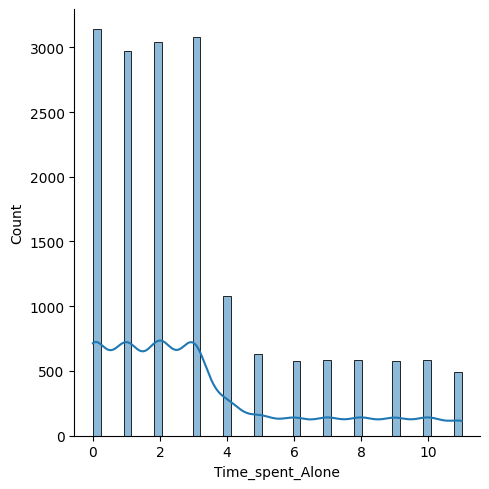

In [10]:
sns.displot(train_df['Time_spent_Alone'],kde = True)

Text(0.5, 1.0, 'Social_event_attendance vs Personlaity')

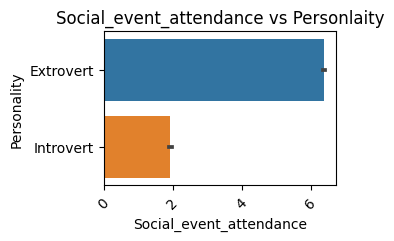

In [11]:
#sns.pairplot(train_df)
#plt.show()
plt.figure(figsize=(3,2))
sns.barplot(x=train_df['Social_event_attendance'], y=train_df['Personality'])
plt.xticks(rotation= 45)
plt.xlabel('Social_event_attendance')
plt.ylabel('Personality')
plt.title('Social_event_attendance vs Personlaity')

Text(0.5, 1.0, 'Time_spent_Alone vs Personlaity')

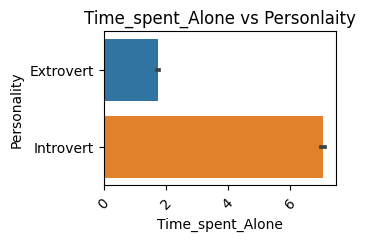

In [12]:
plt.figure(figsize=(3,2))
sns.barplot(x=train_df['Time_spent_Alone'], y=train_df['Personality'])
plt.xticks(rotation= 45)
plt.xlabel('Time_spent_Alone')
plt.ylabel('Personality')
plt.title('Time_spent_Alone vs Personlaity')

Text(0.5, 1.0, 'Going_outside vs Personlaity')

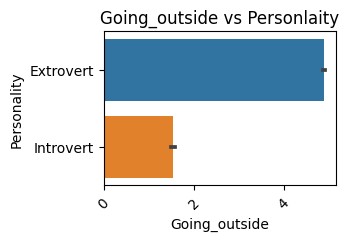

In [13]:
plt.figure(figsize=(3,2))
sns.barplot(x=train_df['Going_outside'], y=train_df['Personality'])
plt.xticks(rotation= 45)
plt.xlabel('Going_outside')
plt.ylabel('Personality')
plt.title('Going_outside vs Personlaity')

Text(0.5, 1.0, 'Friends_circle_size vs Personlaity')

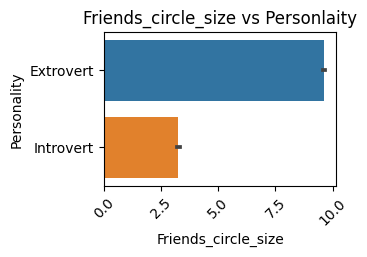

In [14]:
plt.figure(figsize=(3,2))
sns.barplot(x=train_df['Friends_circle_size'], y=train_df['Personality'])
plt.xticks(rotation= 45)
plt.xlabel('Friends_circle_size')
plt.ylabel('Personality')
plt.title('Friends_circle_size vs Personlaity')

In [15]:
y = train_df.iloc[:, -1]
y.head()

0    Extrovert
1    Extrovert
2    Introvert
3    Extrovert
4    Extrovert
Name: Personality, dtype: object

In [16]:
X = train_df.iloc[:, :-1]
X.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,0,0.0,No,6.0,4.0,No,15.0,5.0
1,1,1.0,No,7.0,3.0,No,10.0,8.0
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0
3,3,3.0,No,7.0,3.0,No,11.0,5.0
4,4,1.0,No,4.0,4.0,No,13.0,NaN


In [17]:
cat_columns = ['Stage_fear', 'Drained_after_socializing']

In [18]:
train_df[cat_columns].isnull().sum()

Stage_fear                   1893
Drained_after_socializing    1149
dtype: int64

In [19]:
train_df['Stage_fear'].unique()

array(['No', 'Yes', nan], dtype=object)

In [20]:
train_df_fill = train_df.copy()
for col in cat_columns:
    if col in train_df_fill.columns: 
        mode_val = train_df_fill[col].mode()[0]
        train_df_fill[col] = train_df_fill[col].fillna(mode_val)
print("\nMethod 1: Filled using a loop for each column's mode:")
print(train_df_fill)


Method 1: Filled using a loop for each column's mode:
          id  Time_spent_Alone Stage_fear  Social_event_attendance  \
0          0               0.0         No                      6.0   
1          1               1.0         No                      7.0   
2          2               6.0        Yes                      1.0   
3          3               3.0         No                      7.0   
4          4               1.0         No                      4.0   
...      ...               ...        ...                      ...   
18519  18519               3.0         No                      7.0   
18520  18520               1.0         No                      6.0   
18521  18521               7.0        Yes                      1.0   
18522  18522               NaN        Yes                      1.0   
18523  18523               1.0         No                      8.0   

       Going_outside Drained_after_socializing  Friends_circle_size  \
0                4.0             

In [21]:
train_df_fill[cat_columns].isna().sum()

Stage_fear                   0
Drained_after_socializing    0
dtype: int64

In [22]:
numerical_cols = [col for col in X.columns if col not in cat_columns]
numerical_cols

['id',
 'Time_spent_Alone',
 'Social_event_attendance',
 'Going_outside',
 'Friends_circle_size',
 'Post_frequency']

In [23]:
for col in numerical_cols:
    if col in train_df_fill.columns: # Ensure the column exists
        # Calculate the mode for the current column. .mode()[0] handles ties by taking the first mode.
        median_val = train_df_fill[col].median()
        train_df_fill[col] = train_df_fill[col].fillna(median_val)
print("\nMethod 1: Filled using a loop for each column's mode:")
print(train_df_fill)


Method 1: Filled using a loop for each column's mode:
          id  Time_spent_Alone Stage_fear  Social_event_attendance  \
0          0               0.0         No                      6.0   
1          1               1.0         No                      7.0   
2          2               6.0        Yes                      1.0   
3          3               3.0         No                      7.0   
4          4               1.0         No                      4.0   
...      ...               ...        ...                      ...   
18519  18519               3.0         No                      7.0   
18520  18520               1.0         No                      6.0   
18521  18521               7.0        Yes                      1.0   
18522  18522               2.0        Yes                      1.0   
18523  18523               1.0         No                      8.0   

       Going_outside Drained_after_socializing  Friends_circle_size  \
0                4.0             

In [24]:
train_df_fill[numerical_cols].isna().sum()

id                         0
Time_spent_Alone           0
Social_event_attendance    0
Going_outside              0
Friends_circle_size        0
Post_frequency             0
dtype: int64

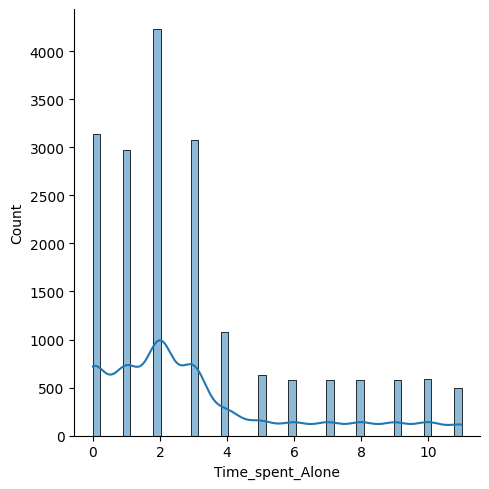

In [25]:
sns.displot(train_df_fill['Time_spent_Alone'],kde = True)

In [26]:
train_df_fill.head(10)

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,No,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,5.0,Extrovert
5,5,2.0,No,8.0,5.0,No,8.0,3.0,Extrovert
6,6,1.0,No,8.0,4.0,No,8.0,4.0,Extrovert
7,7,2.0,No,8.0,3.0,No,4.0,5.0,Extrovert
8,8,4.0,Yes,2.0,1.0,No,0.0,2.0,Introvert
9,9,1.0,No,8.0,6.0,No,14.0,9.0,Extrovert


In [27]:
test_df.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,18524,3.0,No,7.0,4.0,No,6.0,NaN
1,18525,NaN,Yes,0.0,0.0,Yes,5.0,1.0
2,18526,3.0,No,5.0,6.0,No,15.0,9.0
3,18527,3.0,No,4.0,4.0,No,5.0,6.0
4,18528,9.0,Yes,1.0,2.0,Yes,1.0,1.0


In [28]:
train_df.isnull().sum()

id                              0
Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64

In [29]:
test_df.isnull().sum()

id                             0
Time_spent_Alone             425
Stage_fear                   598
Social_event_attendance      397
Going_outside                466
Drained_after_socializing    432
Friends_circle_size          350
Post_frequency               408
dtype: int64

In [30]:
lenc = LabelEncoder()

In [39]:
for i in cat_columns:
    train_df_fill[i] = lenc.fit_transform(train_df_fill[i])
train_df_fill['Personality'] = lenc.fit_transform(train_df_fill['Personality'])

In [40]:
train_df_fill.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,0,6.0,4.0,0,15.0,5.0,0
1,1,1.0,0,7.0,3.0,0,10.0,8.0,0
2,2,6.0,1,1.0,0.0,0,3.0,0.0,1
3,3,3.0,0,7.0,3.0,0,11.0,5.0,0
4,4,1.0,0,4.0,4.0,0,13.0,5.0,0


In [35]:
#test_df['Stage_fear'] = lenc.fit_transform(test_df['Stage_fear'])
#train_df['Drained_after_socializing'] = lenc.fit_transform(train_df['Drained_after_socializing'])
#train_df['Personality'] = lenc.fit_transform(train_df['Personality'])
#test_df['Drained_after_socializing'] = lenc.fit_transform(test_df['Drained_after_socializing'])

In [32]:
train_df.shape

(18524, 9)

In [33]:
train_df['Personality'].value_counts()

Personality
Extrovert    13699
Introvert     4825
Name: count, dtype: int64